In [2]:
import os
2*2*2*3

24

In [22]:
for l in [0,1,2]:
    for nres in [1,5]:
        for feat in [64, 128]:
            for nit in [4, 5]:
                job = f"""sbatch --export=ALL,max_degree={l},nres={nres},num_iterations={nit},features={feat},data=/pchem-data/meuwly/boittier/home//cf3criegee_27887.npz,name=cf3all,natoms=8,totalchg=0.0,ntrain=23887,nvalid=4000,nepochs=50000,batch_size=8,schedule="constant" ./submit-job.sh
                """
                os.system(job)

Submitted batch job 6407
Submitted batch job 6408
Submitted batch job 6409
Submitted batch job 6410
Submitted batch job 6411
Submitted batch job 6412
Submitted batch job 6413
Submitted batch job 6414
Submitted batch job 6415
Submitted batch job 6416
Submitted batch job 6417
Submitted batch job 6418
Submitted batch job 6419
Submitted batch job 6420
Submitted batch job 6421
Submitted batch job 6422
Submitted batch job 6423
Submitted batch job 6424
Submitted batch job 6425
Submitted batch job 6426
Submitted batch job 6427
Submitted batch job 6428
Submitted batch job 6429
Submitted batch job 6430


In [2]:
from pathlib import Path
outfiles = list(Path("/pchem-data/meuwly/boittier/home/pycharmm_test/slurm").glob("*.out"))

In [3]:
files = []
ls = []
fs = []
nits = []
for of in outfiles:
    with open(of) as f:
        lines = f.readlines()
        sel = [bytes(_, "utf8").decode("utf8") for _ in lines if "cf3all-" in _]
        sel2 = [bytes(_, "utf8").decode("utf8") for _ in lines if "epoch" in _]
        files.append("".join([sel[0].strip(),sel2[2].strip()]).strip())
        l = [int(_.split("=")[-1].strip()) for _ in lines[:100] if _.startswith("    max_degree")]
        f = [int(_.split("=")[-1].strip()) for _ in lines[:100] if _.startswith("    feat")]
        nit = [int(_.split("=")[-1].strip()) for _ in lines[:100] if _.startswith("    num_i")]
        ls.append(l)
        fs.append(f)
        nits.append(nit)

In [4]:
from physnetjax.tensorboard_interface import process_tensorboard_logs
from physnetjax.plot_run import  plot_run
import polars as pl

2024-12-12 07:39:22.934679: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-12 07:39:23.132269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733985563.155106 2375689 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733985563.159835 2375689 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 07:39:23.175057: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
df = process_tensorboard_logs("/pchem-data/meuwly/boittier/home/pycharmm_test/ckpts/cf3all-ce7c2667-4651-4e77-9565-f8490753329a/tfevents/")

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [6]:
dfs = [process_tensorboard_logs(Path(f.split("epoch-")[0][4:] + "tfevents/")) for f in files]

In [7]:
# dfs = pl.concat(dfs)

In [8]:
new_dfs = []
for i in range(len(files)):
    _ = dfs[i].with_columns(
        pl.col("epoch")
        .map_elements(lambda x: ls[i][0], return_dtype=pl.Int64)
        .alias("l")
    )
    _ = _.with_columns(pl.col("epoch").map_elements(lambda x: nits[i][0], return_dtype=pl.Int64).alias("nit"))
    new_dfs.append(_.with_columns(
    pl.col("epoch").map_elements(lambda x: fs[i][0], return_dtype=pl.Int64).alias("f")))
    

In [9]:
new_dfs = pl.concat(new_dfs)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 

m = ["o", "X"]

def plot_run(base_df):
    for i, ycol in enumerate(["train_loss"]):
        sns.lineplot(base_df, x="epoch", y=ycol, hue="l", style="f", size="nit", 
                     # markers=[m[i] for _ in range(2)]
                    )
    plt.ylim(0,4)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    for i, ycol in enumerate(["valid_loss"]):
        sns.lineplot(base_df, x="epoch", y=ycol, hue="l", style="f", size="nit", 
                     # markers=[m[i] for _ in range(2)]
                    )
    plt.ylim(0,4)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    for i, ycol in enumerate(["train_energy_mae",]):
        sns.lineplot(base_df, x="epoch", y=ycol, hue="l", style="f",  size="nit",
                     # markers=[m[i] for _ in range(2)]
                    )
    plt.ylim(0,5)
    plt.axhline(0.01749)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    for i, ycol in enumerate([ "valid_energy_mae"]):
        sns.lineplot(base_df, x="epoch", y=ycol, hue="l", style="f",  size="nit", 
                     # markers=[m[i] for _ in range(2)]
                    )
    plt.ylim(0,5)
    plt.axhline(0.01749)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    for i, ycol in enumerate(["train_forces_mae",]):
        sns.lineplot(base_df, x="epoch", y=ycol, hue="l", style="f",  size="nit",
                     # markers=[m[i] for _ in range(2)]
                    )
    plt.ylim(0,1.5)
    plt.axhline(0.01749)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

    for i, ycol in enumerate([ "valid_forces_mae"]):
        sns.lineplot(base_df, x="epoch", y=ycol, hue="l", style="f",  size="nit", 
                     # markers=[m[i] for _ in range(2)]
                    )
    plt.ylim(0,1.5)
    plt.axhline(0.01749)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

new_dfs = new_dfs.with_columns(
    pl.col("log")
    .map_elements(lambda x: x.split("/")[-3], return_dtype=pl.String)
    .alias("uuid")
)

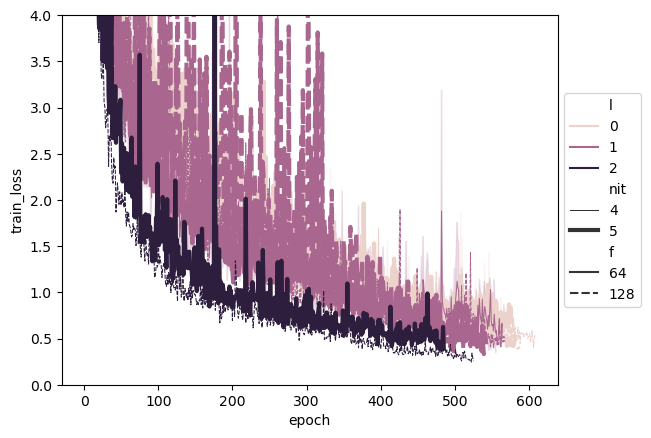

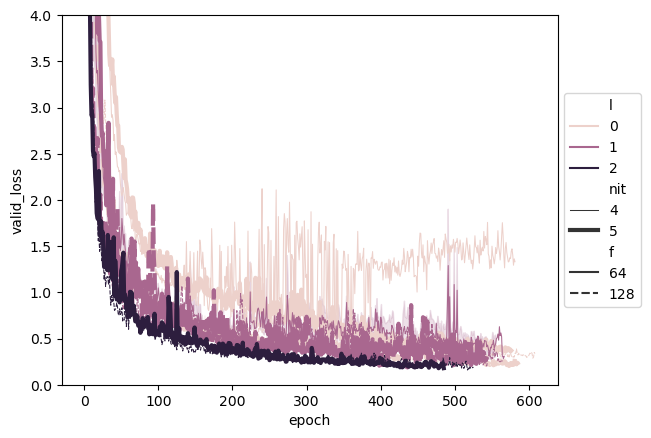

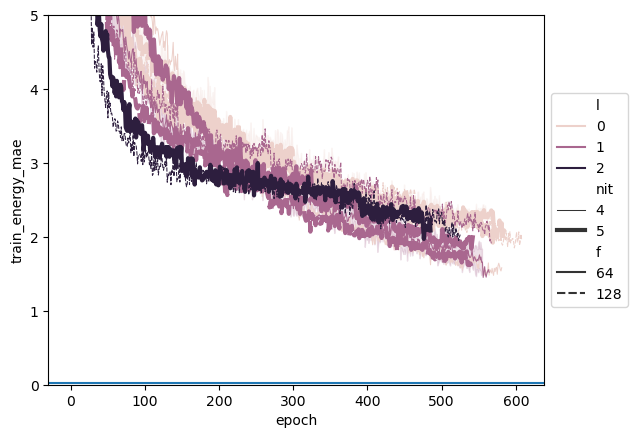

In [ ]:
plot_run(new_dfs)

In [ ]:
new_dfs.describe()